## Model description

https://easychair.org/publications/paper/1ff2

Three-dimensional ODE of the plant without discrete-time PI-controller:

$$
   \left\{ \begin{array}{lcl}
   \dot{I} & = & \frac{1}{L}\cdot\left( \left(K_P\cdot\left(x_0-x\right)+K_I\cdot x_c \right) - I\cdot\left(R - \frac{K^2}{d_{rot}}\right)\right) \\
   \dot{x} & = & \frac{K}{i\cdot d_{rot}}\cdot I \\
   \dot{x_c} & = & x_0-x \end{array}
   \right.
$$

In [ ]:
# ] add https://github.com/JuliaReach/Reachability.jl.git#mforets/no_logger

In [229]:
using Reachability, TaylorIntegration, MathematicalSystems, HybridSystems
using SparseArrays

In [230]:
# model's constants
L       = 1.e-3;
KP      = 10000.;
KI      = 1000.;
R       = 0.3;
K       = 0.02;
drot    = 0.1;
i       = 113.1167;
Tsample = 1.E-4;

# define "braking mode"
# x' =  Ax + b
#A = [(R+K^2/drot)/L 0.0 0.0 KP/L KI/L; K/i/drot 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0];
#b = [0.0, 0.0, 1.0, 0.0, 0.0]
A = sparse([1, 1, 1, 2], [1, 4, 5, 1], [-(R+K^2/drot)/L, KP/L, KI/L, K/i/drot], 5, 5);
b = sparsevec([3], [1.], 5);

# para probar: agrego la ecuacion xe = x0 - x
#x0 = 0.05
#A = sparse([1, 1, 1, 2, 4], [1, 4, 5, 1, 2], [-(R+K^2/drot)/L, KP/L, KI/L, K/i/drot, -1.0], 5, 5);
#b = sparsevec([3, 4], [1., x0], 5);

X = HalfSpace([0.0, 0.0, 1.0, 0.0, 0.0], Tsample); # invariant
#X = Universe(5)

braking = ConstrainedAffineContinuousSystem(A, b, X)

modesvec = [braking]

1-element Array{ConstrainedAffineContinuousSystem{Float64,SparseMatrixCSC{Float64,Int64},SparseVector{Float64,Int64},Universe{Float64}},1}:
 ConstrainedAffineContinuousSystem{Float64,SparseMatrixCSC{Float64,Int64},SparseVector{Float64,Int64},Universe{Float64}}(
  [1, 1]  =  -304.0
  [2, 1]  =  0.00176809
  [1, 4]  =  1.0e7
  [1, 5]  =  1.0e6,   [3]  =  1.0, Universe{Float64}(5))

In [231]:
I₀  = Singleton([0.0]); #Interval(0., 0.);
x₀  = Singleton([0.0]); #Interval(0., 0.);
T₀  = Singleton([0.0]); #Interval(0., 0.);
xe₀ = Singleton([0.0]); #Interval(0., 0.);
xc₀ = Singleton([0.0]); #Interval(0., 0.);

X₀ = I₀ × x₀ × T₀ × xe₀ × xc₀;
#X₀ = X₀ ⊕ BallInf(zeros(dim(X₀)), 0.0001);

## Solucion del problema lineal

In [142]:
typeof(braking)

ConstrainedAffineContinuousSystem{Float64,SparseMatrixCSC{Float64,Int64},SparseVector{Float64,Int64},Universe{Float64}}

In [156]:
P = InitialValueProblem(braking, X₀);

In [225]:
sol = solve(P, Options(:T => 0.4, :verbosity=>2), op=BFFPSV18(:δ=>0.00001));

[info] Reachable States Computation...


MethodError: MethodError: no method matching reach(::InitialValueProblem{BlackBoxContinuousSystem{typeof(EMBrake!)},CartesianProduct{Float64,CartesianProduct{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}},Interval{Float64,IntervalArithmetic.Interval{Float64}}},Interval{Float64,IntervalArithmetic.Interval{Float64}}}}, ::Reachability.TwoLayerOptions)
Closest candidates are:
  reach(!Matched::Union{InitialValueProblem{#s124,#s123} where #s123<:LazySet{NUM<:Real} where #s124<:(ConstrainedLinearDiscreteSystem{NUM<:Real,MT,ST} where ST where MT<:AbstractArray{NUM<:Real,2}), InitialValueProblem{#s122,#s121} where #s121<:LazySet{NUM<:Real} where #s122<:(ConstrainedLinearControlDiscreteSystem{NUM<:Real,MTA,MTB,ST,UT} where UT where ST where MTB<:AbstractArray{NUM<:Real,2} where MTA<:AbstractArray{NUM<:Real,2})}, ::Reachability.TwoLayerOptions) where NUM<:Real at /home/mforets/.julia/dev/Reachability/src/ReachSets/ContinuousPost/BFFPSV18/reach.jl:36
  reach(!Matched::Union{InitialValueProblem{#s223,#s222} where #s222<:LazySet{NUM<:Real} where #s223<:(ConstrainedLinearContinuousSystem{NUM<:Real,MT,ST} where ST where MT<:AbstractArray{NUM<:Real,2}), InitialValueProblem{#s221,#s220} where #s220<:LazySet{NUM<:Real} where #s221<:(ConstrainedLinearControlContinuousSystem{NUM<:Real,MTA,MTB,ST,UT} where UT where ST where MTB<:AbstractArray{NUM<:Real,2} where MTA<:AbstractArray{NUM<:Real,2})}, ::Reachability.TwoLayerOptions) where NUM<:Real at /home/mforets/.julia/dev/Reachability/src/ReachSets/ContinuousPost/BFFPSV18/reach.jl:211

In [166]:
for i in 19:21
    x3 = overapproximate(project(sol.Xk[i].rs.X, [3], LazySets.LinearMap), Interval)
    println(x3)
end

Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.0018, 0.00190001])
Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.0019, 0.00200001])
Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.002, 0.00210001])


In [167]:
dim(sol.Xk[1].rs.X)

5

In [168]:
length(sol.Xk)

4000

In [169]:
Xk_1 = [project(sol.Xk[i].rs.X, [1], LazySets.LinearMap) for i in eachindex(sol.Xk)];

tiempos = [LazySets.Interval(sol.Xk[i].rs.t_start, sol.Xk[i].rs.t_end) for i in eachindex(sol.Xk)]

Xk_1t = [tiempos[i] × Xk_1[i] for i in eachindex(tiempos)];

# pasar a hyperrectangle
Xk_1t = [overapproximate(y, Hyperrectangle) for y in Xk_1t];

In [170]:
using Plots

In [171]:
N = length(Xk_1t)

4000

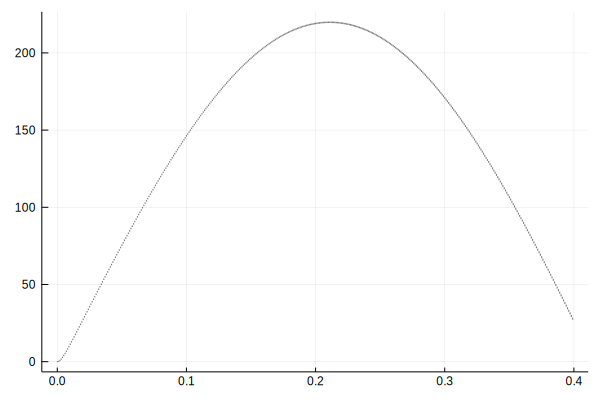

In [175]:
plot([Xk_1t[i] for i in 1:10:N])

## Solucion del problema hibrido

In [234]:
brake = LightAutomaton(1)

A = sparse([1, 1, 1, 2], [1, 4, 5, 1], [-(R+K^2/drot)/L, KP/L, KI/L, K/i/drot], 5, 5)
b = sparsevec([3], [1.], 5)
X = HalfSpace([0.0, 0.0, 1.0, 0.0, 0.0], Tsample) # invariant
braking = ConstrainedAffineContinuousSystem(A, b, X)
modesvec = [braking]

# add_transition!(model name, initial model number, final model number, tag/label)
add_transition!(brake, 1, 1, 1)

x0 = 0.05
A = sparse([1, 2, 4, 5, 5], [1, 2, 2, 2, 5], [1., 1., -1., -Tsample, 1.], 5, 5);
b = sparsevec([4, 5], [x0, Tsample*x0], 5)
guard = HalfSpace([0.0, 0.0, -1.0, 0.0, 0.0], Tsample); # T >= Tsample

resetmaps = [ConstrainedAffineMap(A, b, guard)]

switchings = [AutonomousSwitching()]

H = HybridSystem(brake, modesvec, resetmaps, switchings)

# initial condition in "braking" mode
EM_Brake = InitialValueProblem(H, [(1, X₀)]);

In [10]:
#X₀ = convert(Zonotope, X₀);
#X₀ = overapproximate(Zonotope, X₀);
#X₀ = convert(Zonotope, overapproximate(X₀, Hyperrectangle));
#X₀ = overapproximate(X₀, Hyperrectangle)

In [255]:
using Reachability: ReachSet, SparseReachSet

Z = rand(Hyperrectangle, dim=2)
ZR = ReachSet(Z, 1.0, 2.0)
ZSR = Reachability.SparseReachSet(ZR, 1:2)

ZSRVECTOR = [ZSR, ZSR]

ReachSolution(ZSRVECTOR, Options(:T=>1.0))

ReachSolution{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},SparseReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}}(SparseReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}[SparseReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(ReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.1481206230466086, -0.743139310325353], [1.6701542874551216, 0.845995360988507]), 1.0, 2.0), 1:2), SparseReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(ReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.1481206230466086, -0.743139310325353], [1.6701542874551216, 0.845995360988507]), 1.0, 2.0), 1:2)], Options(Dict{Symbol,Any}(:T => 1.0)))

In [256]:
typeof(ZSRVECTOR)

Array{SparseReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}

In [251]:
#opC = GLGM06(Options(:δ=>0.04));
opC = BFFPSV18(Options(:δ=>0.0001));
opD = LazyDiscretePost() # :check_invariant_intersection => true);
sol = solve(EM_Brake, Options(:T=>0.2, :max_jumps=>2), opC, opD);

MethodError: MethodError: no method matching ReachSolution(::Array{SparseReachSet,1}, ::Options)
Closest candidates are:
  ReachSolution(!Matched::Array{RSN<:AbstractReachSet{SN},1}, ::Reachability.AbstractOptions) where {SN, RSN<:AbstractReachSet{SN}} at /home/mforets/.julia/dev/Reachability/src/ReachSets/ReachSolution.jl:13

In [244]:
sol.Xk

3-element Array{SparseReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}:
 SparseReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(ReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0, 5.000000087181681e-5, 0.0, 0.0], [2.6019257177938035e-20, 2.6019257177938035e-20, 5.0000000871816836e-5, 2.6019257177938035e-20, 2.6019257177938035e-20]), 0.0, 0.001), [1, 2, 3, 4, 5])                                                             
 SparseReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(ReachSet{Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([257.73957542838156, 0.00040044111520745135, 5.000000087181677e-5, 0.04999999999999432, 4.999999999999432e-6], [257.73957542838156, 0.0004904398722949082, 5.0000000871816876e-5, 5.6968318951078345e-15, 6.988021814847978e-19]), 0.0, 0.002), [1, 2, 

In [14]:
Xk_1 = [project(sol.Xk[i].X, [1], LazySets.LinearMap) for i in eachindex(sol.Xk)];

tiempos = [LazySets.Interval(sol.Xk[i].t_start, sol.Xk[i].t_end) for i in eachindex(sol.Xk)]

Xk_1t = [tiempos[i] × Xk_1[i] for i in eachindex(tiempos)];

plot(Xk_1t)

UndefVarError: UndefVarError: sol not defined

In [ ]:
#using SparseArrays
#S = sparse([1, 2], [1, 2], [-1.0, 1.0], 2, 2)
#Matrix(S)

In [ ]:
# @variables x[1:5]
# H = @set x[3] >= 0

# FUTURO
#@variables I x T xₑ xc
#X = @set T <= Tsample
#falling = @system x' = Ax + b, x ∈ X

In [257]:
struct miPunto{T}
    x::T
    y::T
    z::T
end

In [259]:
miPunto(1.0, 1.0, 1.0)

miPunto{Float64}(1.0, 1.0, 1.0)

In [260]:
miPunto(1, 1, 1)

miPunto{Int64}(1, 1, 1)

In [271]:
miPunto("a", "b", "c")

miPunto{String}("a", "b", "c")

In [263]:
vconcreto = [miPunto(1, 1, 1), miPunto(2, 2, 2)]

2-element Array{miPunto{Int64},1}:
 miPunto{Int64}(1, 1, 1)
 miPunto{Int64}(2, 2, 2)

In [262]:
function f(a::Vector{miPunto{T}}) where {T}
    sum([ai.x for ai in a])
end

f (generic function with 1 method)

In [ ]:
function h(p::miPunto)
    return p.x
end

function h(p::miPunto{Float64})
    return p.y
end

In [264]:
f(vconcreto)

3

In [266]:
vunstable = [miPunto(1, 1, 1), miPunto(2.0, 2.0, 2.0)]

2-element Array{miPunto,1}:
 miPunto{Int64}(1, 1, 1)        
 miPunto{Float64}(2.0, 2.0, 2.0)

In [267]:
f(vunstable)

MethodError: MethodError: no method matching f(::Array{miPunto,1})
Closest candidates are:
  f(!Matched::Array{miPunto{T},1}) where T at In[262]:2

In [268]:
function g(a)
    sum([ai.x for ai in a])
end

g (generic function with 1 method)

In [269]:
g(vunstable)

3.0

# Solver lineal

In [226]:
function EMBrake_lineal()
    local L    = 1.e-3
    local KP   = 10000.
    local KI   = 1000.
    local x0   = 0.05
    local R    = 0.3
    local K    = 0.02
    local drot = 0.1
    local i    = 113.1167
    
    #du[1] = 1/L * (KP * (x0-u[2]) + KI * u[3] - u[1] * (R + K^2/drot))
    #du[2] = u[1] * K/i/drot
    #du[3] = x0 - u[2]
    
    A = [-(R + K^2/drot)/L   -KP/L    KI/L;
          K/(i*drot)         0.0     0.0;
              0              -1.0      0]
    b = [x0*KP/L, 0.0, x0]

    return AffineContinuousSystem(A, b)
end

EMBrake_lineal (generic function with 1 method)

In [228]:
S = EMBrake_lineal()
I₀  = Interval(0., 0.)
x₀  = Interval(0., 0.)
xc₀ = Interval(0., 0.)
X₀ = I₀ × x₀ × xc₀;
P = InitialValueProblem(S, X₀)

sol = solve(P, Options(:T => 0.2, :verbosity=>2), op=BFFPSV18(:δ=>2.5e-8));

[info] Reachable States Computation...
[info] Time discretization...
[info] elapsed time: 2.708e-04 seconds
[info] - Decomposing X0
[info] elapsed time: 2.503e-05 seconds
[info] - Computing successors


Computing successors   8%|██▌                           |  ETA: 0:02:20

InterruptException: InterruptException:

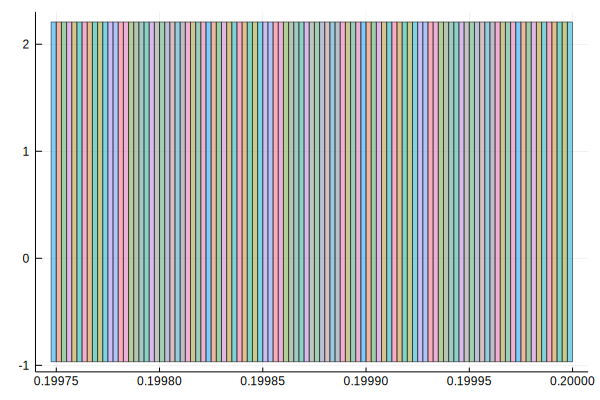

In [215]:
Xk_1 = [project(sol.Xk[i].rs.X, [1], LazySets.LinearMap) for i in eachindex(sol.Xk)];

tiempos = [LazySets.Interval(sol.Xk[i].rs.t_start, sol.Xk[i].rs.t_end) for i in eachindex(sol.Xk)]

Xk_1t = [tiempos[i] × Xk_1[i] for i in eachindex(tiempos)];

plot([Xk_1t[i] for i in length(Xk_1t)-100:length(Xk_1t)])

# Solver no lineal

## Reachability settings

In [216]:
@taylorize function EMBrake!(du, u, p, t)
    local L    = 1.e-3
    local KP   = 10000.
    local KI   = 1000.
    local x0   = 0.05
    local R    = 0.3
    local K    = 0.02
    local drot = 0.1
    local i    = 113.1167
    
    du[1] = 1/L * (KP * (x0-u[2]) + KI * u[3] - u[1] * (R + K^2/drot))
    du[2] = u[1] * K/i/drot
    du[3] = x0 - u[2]

end

In [217]:
I₀  = Interval(0., 0.)
x₀  = Interval(0., 0.)
xc₀ = Interval(0., 0.)

X₀ = I₀ × x₀ × xc₀

CartesianProduct{Float64,CartesianProduct{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}},Interval{Float64,IntervalArithmetic.Interval{Float64}}},Interval{Float64,IntervalArithmetic.Interval{Float64}}}(CartesianProduct{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}},Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 0]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 0])), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 0]))

In [218]:
S = BlackBoxContinuousSystem(EMBrake!, 3)
P = InitialValueProblem(S, X₀);

## Results

In [219]:
sol = solve(P, Options(:T=>0.2),
            op=TMJets(Options(:max_steps=>10_000, :abs_tol=>1e-10, :orderT=>6, :orderQ=>2,:output_type=>Zonotope)));

In [ ]:
#using Pkg
#Pkg.add("LaTeXStrings")
using Plots, LaTeXStrings

### I vs $x_c$

In [180]:
Xk_13 = [project(sol.Xk[i].X, [1, 3], LazySets.LinearMap) for i in eachindex(sol.Xk)];

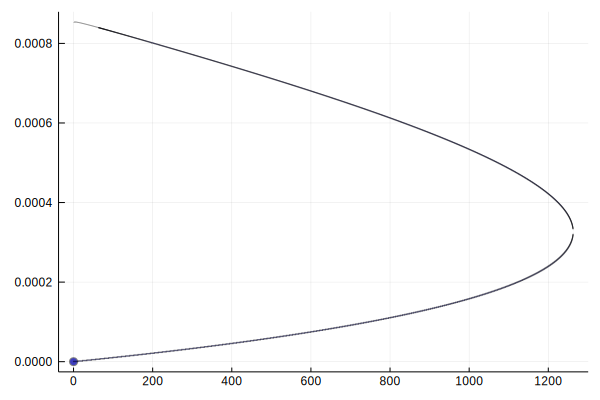

In [181]:
plot(Xk_13, color=:blue)

### I vs t

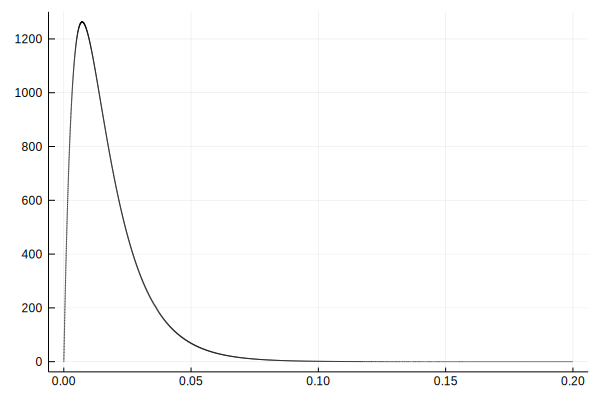

In [221]:
Xk_1 = [project(sol.Xk[i].X, [1], LazySets.LinearMap) for i in eachindex(sol.Xk)];

tiempos = [LazySets.Interval(sol.Xk[i].t_start, sol.Xk[i].t_end) for i in eachindex(sol.Xk)]

Xk_1t = [tiempos[i] × Xk_1[i] for i in eachindex(tiempos)];

plot(Xk_1t)

In [223]:
length(Xk_1t)

1261

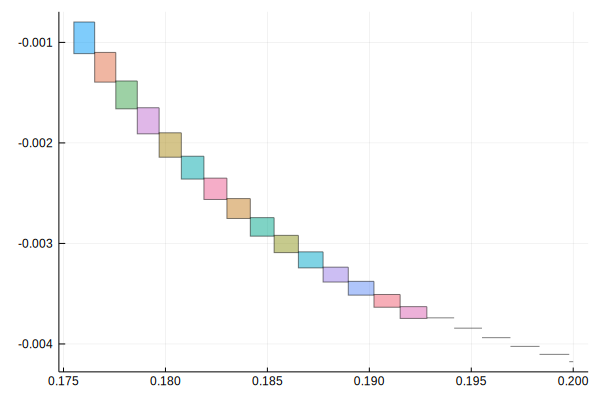

In [224]:
plot([Xk_1t[i] for i in length(Xk_1t)-20:length(Xk_1t)])

In [209]:
import IntervalArithmetic

deltas = [IntervalArithmetic.diam(tiempos[i].dat) for i in 1:length(tiempos)];
minimum(deltas), maximum(deltas)

(2.273566674913564e-5, 0.0014584524142260413)

In [ ]:
Xk_2 = [project(sol.Xk[i].X, [2], LazySets.LinearMap) for i in eachindex(sol.Xk)];

#tiempos = [LazySets.Interval(sol.Xk[i].t_start, sol.Xk[i].t_end) for i in eachindex(sol.Xk)]

Xk_2t = [tiempos[i] × Xk_2[i] for i in eachindex(tiempos)];

plot(Xk_2t)